In [1]:
"hi"

'hi'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.plotting_tools.Bins import bins
from ROOT import TH1F
import array
import subprocess
import uncertainties as unc
from uncertainties import unumpy

from scipy.integrate import quad
from scipy.interpolate import interp1d

Welcome to JupyROOT 6.22/09


In [219]:
from src.plotting_tools.utils import calc_bin_widths, calc_bin_centers
from src.plotting_tools.SysHist import SysHist
from src.data_tools.StackPlotter import get_stack_plotter
from src.plotting_tools.utils import rebin_np, rebin_integrate
from src.plotting_tools.cms_format import cms_format_fig, cms_style
from src.plotting_tools.Bins import Bins
from src.assets.lumi import lumi_dict

ImportError: cannot import name 'rebin_integrate' from 'src.plotting_tools.utils' (/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/src/plotting_tools/utils.py)

In [5]:
cms_style()

In [6]:
def make_hist(values, errors, bin_edges, *args):
    hpx    = TH1F(*args, len(bin_edges)-1, array.array('d', bin_edges))
    for i, (x,e) in enumerate(zip(values,errors)):
        hpx.SetBinContent(i, x) 
        hpx.SetBinError(i, e) 
    return hpx


In [7]:
def add_overflow(arr, top=0, bottom=0):
    return   np.concatenate([[bottom],arr,[top]])

In [8]:
# http://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/part2/settinguptheanalysis/
# https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/blob/102x/data/tutorials/shapes/simple-shapes-df_input.csv

In [43]:
from src.assets.output_dir import output_dir
outdir = output_dir
era = '2016'
lumi_fraction = lumi_dict[str(era)]/lumi_dict['201X']
#rootfname = '{outdir}/combine_data/{era}/{era}_shapes_df_input.root'.format(outdir=outdir, era=era)

In [10]:
if era=='2016':
    lumi=1.025
    uncorr = 1.01
    corr_1 = 1.006
    corr_2 = 1.0
    lumi_str = f'''
lumi_uncorr_{era} lnN -      {uncorr}
lumi_corr1 lnN -      {corr_1}
'''
if era=='2017':
    lumi=1.023
    uncorr = 1.02
    corr_1 = 1.009
    corr_2 = 1.006
    lumi_str = f'''
lumi_uncorr_{era} lnN -      {uncorr}
lumi_corr1 lnN -      {corr_1}
lumi_corr2  lnN -      {corr_2}
'''
if era=='2018':
    lumi=1.025
    uncorr = 1.015
    corr_1 = 1.02
    corr_2 = 1.002
    lumi_str = f'''
lumi_uncorr_{era} lnN -      {uncorr}
lumi_corr1 lnN -      {corr_1}
lumi_corr2  lnN -      {corr_2}
'''
print(lumi_str)


lumi_uncorr_2017 lnN -      1.02
lumi_corr1 lnN -      1.009
lumi_corr2  lnN -      1.006



In [11]:
sp = get_stack_plotter(outdir, era)
data_dict = {}
data_dict['SR1'] = sp.make_data_hist('DiLepMass','SR1', blinded=False)
data_dict['SR2'] = sp.make_data_hist('DiLepMass','SR2', blinded=False)

In [12]:
with open('{}/data/{}_bff_interp_dbs_norm.pkl'.format(outdir, era), 'rb') as f:
    data = pkl.load(f)

masses = data.mass.unique()
masses = masses[masses<355]
full_masses= True
masses = masses if full_masses else [125, 150, 175, 200, 250, 300, 350]

In [13]:
outname="{}/abcd/abcd_dict_data_{}_ismc0.pkl".format(outdir, era)
with open(outname,'rb') as f:
    abcd = pkl.load(f)
    
outname="{}/abcd/ABCD_closure_unc.pkl".format(outdir, era)
with open(outname, 'rb') as f:
    uncertainty_dict= pkl.load(f)
    
    
    print(pd.DataFrame(uncertainty_dict))
uncertainty_dict = {k:v+1 for k,v in uncertainty_dict[int(era)].items()}

     2016  2017  2018
SR1  0.23  0.17  0.17
SR2  0.19  0.21  0.17


In [14]:
##
## Make acceptance details
##

In [15]:
accpt_df = pd.read_csv('/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23'+"/data_gen_b_s/summary_df.csv")
accpt_df

isrfsr = abs((accpt_df['Weight_ISRFSR_Up']-accpt_df['Weight_ISRFSR_Down']))/(accpt_df['acceptance']*2)

pdf = abs(accpt_df['Weight_PDF_Up']-accpt_df['Weight_PDF_Down'])/(accpt_df['acceptance']*2)

min(isrfsr), max(isrfsr), np.mean(isrfsr), min(pdf), max(pdf), np.mean(pdf)


(0.0,
 0.0698031381307393,
 0.020254437699628636,
 0.0,
 0.0018281665853736263,
 0.0008845405663566542)

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic

In [17]:
def GPR_fit_and_predict(x,y,std, xp, plot=False, length_scale_bounds=(100,10000),alpha=1e-1):
    kernel = 1 * RBF(length_scale=100, length_scale_bounds=length_scale_bounds)
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, random_state=0, alpha=alpha, normalize_y=True)
    gaussian_process.fit(x, y)
    #predict
    mean_prediction, std_prediction = gaussian_process.predict(xp, return_std=True)
    mean_prediction = mean_prediction.reshape(-1)
    if plot:
        plot.errorbar(x, y, yerr=std, label='Data')
        #gpr:
        plot.plot(xp, mean_prediction, color='orange', label='GPR Fit')
        plot.fill_between(xp.reshape(-1),  mean_prediction+std_prediction, mean_prediction-std_prediction, alpha=.5, color='orange')
    return  mean_prediction, std_prediction

In [18]:
def extend_accpt_df(reg, sig_type):
    tadf = accpt_df[(accpt_df.reg==reg) & (accpt_df.type==sig_type)]

    #accp
    fig, ax = plt.subplots()
    cms_format_fig(era, ax, "\emph{Simulation}")
    ax.set_ylabel('Acceptance')
    ax.set_xlabel('$m_{Z\prime}$ [GeV]')
    ax.legend(title=f'{reg} {sig_type}')
    accep, stat = GPR_fit_and_predict(tadf.mass.to_numpy().reshape(-1, 1), tadf.acceptance.to_numpy().reshape(-1, 1), tadf.statistical.to_numpy(),
       masses.reshape(-1,1), plot=ax, length_scale_bounds=(100,10000), alpha=tadf.statistical.to_numpy()*1e1)
    
    
    fig, ax = plt.subplots()
    cms_format_fig(era, ax, "\emph{Simulation}")
    ax.set_ylabel('ISR/FSR Weight')
    ax.set_xlabel('$m_{Z\prime}$ [GeV]')
    ax.legend(title=f'{reg} {sig_type}')
    Weight_ISRFSR_Up, _  = GPR_fit_and_predict(tadf.mass.to_numpy().reshape(-1, 1), tadf.Weight_ISRFSR_Up.to_numpy().reshape(-1, 1), 0*tadf.statistical.to_numpy(),
       masses.reshape(-1,1), plot=ax, length_scale_bounds=(100,10000), alpha=2e-1)
    
    Weight_ISRFSR_Down, _  = GPR_fit_and_predict(tadf.mass.to_numpy().reshape(-1, 1), tadf.Weight_ISRFSR_Down.to_numpy().reshape(-1, 1), 0*tadf.statistical.to_numpy(),
       masses.reshape(-1,1), plot=ax, length_scale_bounds=(100,10000), alpha=2e-1)
    
    fig, ax = plt.subplots()
    cms_format_fig(era, ax, "\emph{Simulation}")
    ax.set_ylabel('PDF Weight')
    ax.set_xlabel('$m_{Z\prime}$ [GeV]')
    ax.legend(title=f'{reg} {sig_type}')
    Weight_PDF_Up, _  = GPR_fit_and_predict(tadf.mass.to_numpy().reshape(-1, 1), tadf.Weight_PDF_Up.to_numpy().reshape(-1, 1), 0*tadf.statistical.to_numpy(),
       masses.reshape(-1,1), plot=ax, length_scale_bounds=(100,10000), alpha=2e-1)

    Weight_PDF_Down, _  = GPR_fit_and_predict(tadf.mass.to_numpy().reshape(-1, 1), tadf.Weight_PDF_Down.to_numpy().reshape(-1, 1), 0*tadf.statistical.to_numpy(),
       masses.reshape(-1,1), plot=ax, length_scale_bounds=(100,10000), alpha=2e-1)
    
    #make df
    df_list = []
    for mass, a, s, ISRFSR_Up, ISRFSR_Down, PDF_up, PDF_Down in zip(masses, accep, stat, Weight_ISRFSR_Up, Weight_ISRFSR_Down, Weight_PDF_Up, Weight_PDF_Down):
        df_list.append({"mass": mass, "reg": reg, "type": sig_type, 
                        "acceptance": a, 'statistical': s, 
                        "Weight_ISRFSR_Up": ISRFSR_Up, "Weight_ISRFSR_Down": ISRFSR_Down,
                        "Weight_PDF_Up": PDF_up, "Weight_PDF_Down": PDF_Down})
    return df_list

No handles with labels found to put in legend.
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
No handles with labels found to put in legend.
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.2

No handles with labels found to put in legend.
No handles with labels found to put in legend.
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
No handles with labels found to put in legend.
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/cvmfs/cms.cern.ch/

/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/cvmfs/cms.cern.ch/

No handles with labels found to put in legend.
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.24.2-cb0f5e37c594bcc77c9bfc04f9ca23ae/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 100. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
No handles with labels found to put in legend.
/cvmfs/cms.cern.ch/slc7_amd64_gcc900/external/py3-scikit-learn/0.2

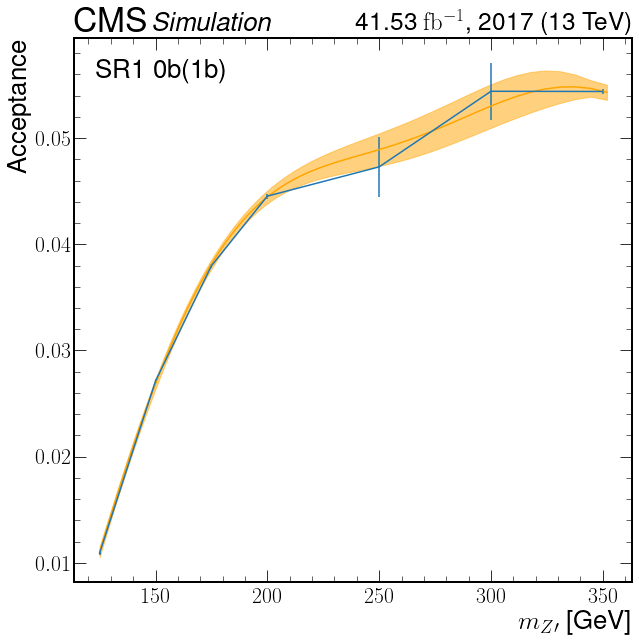

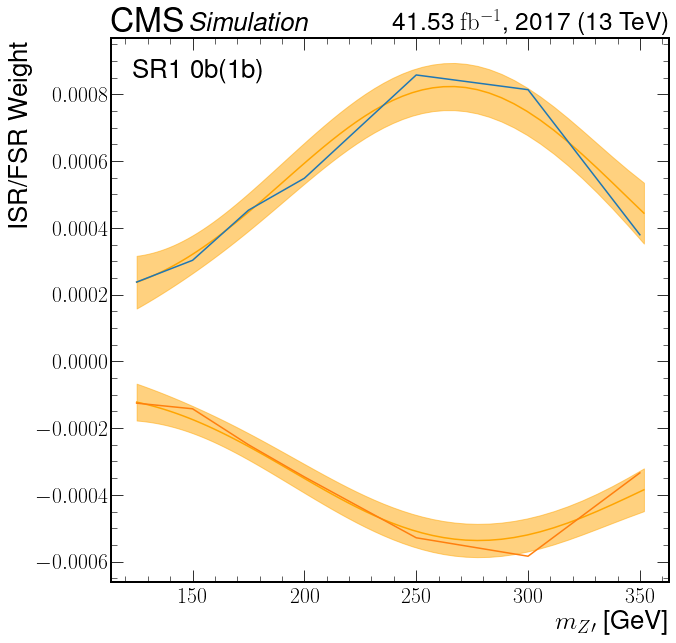

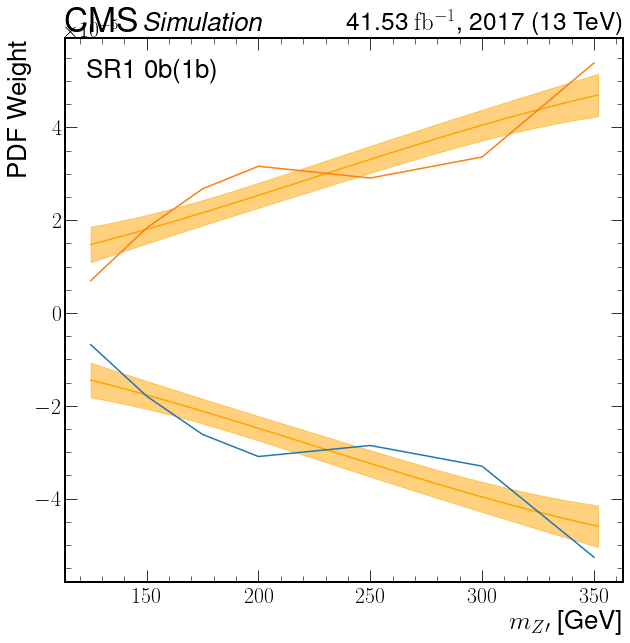

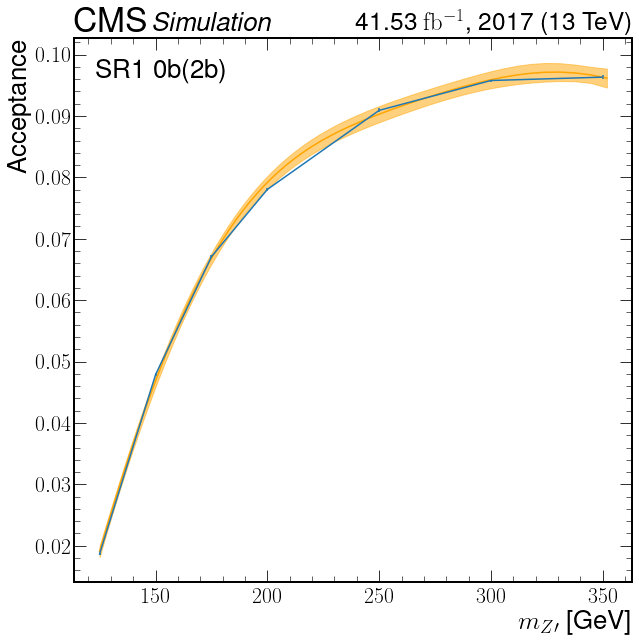

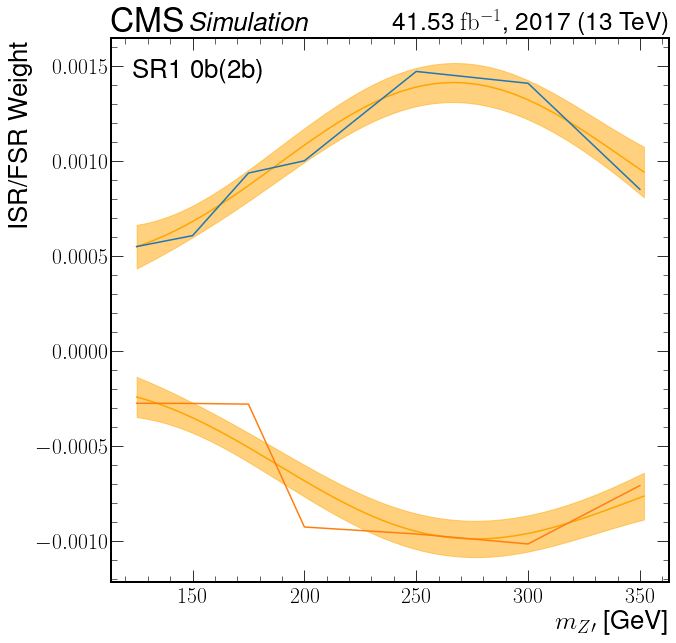

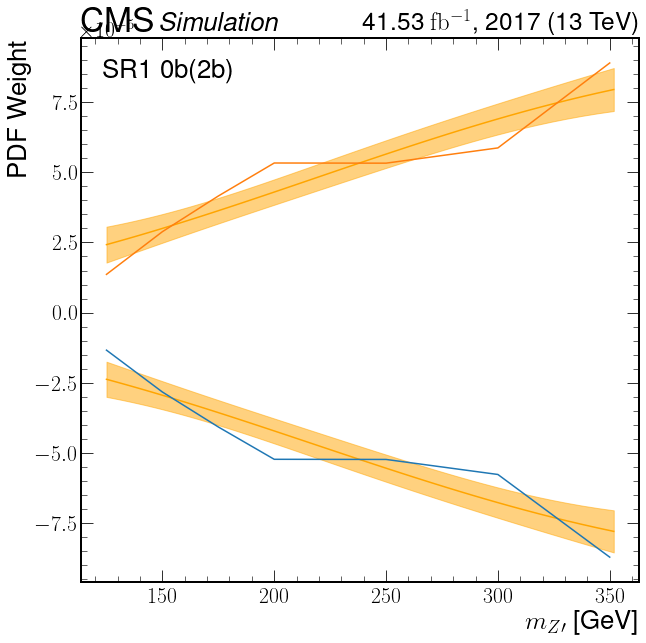

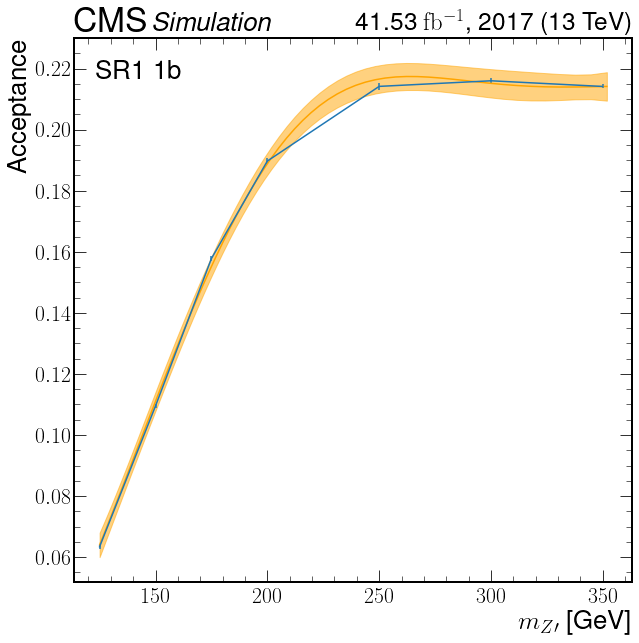

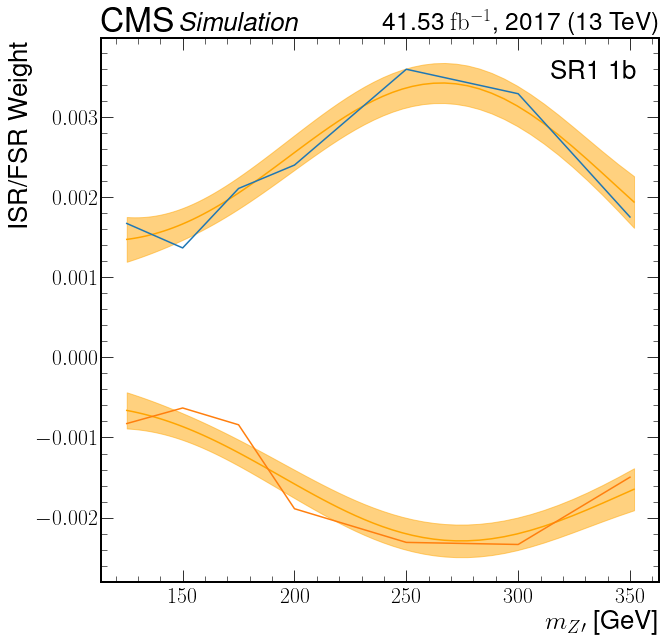

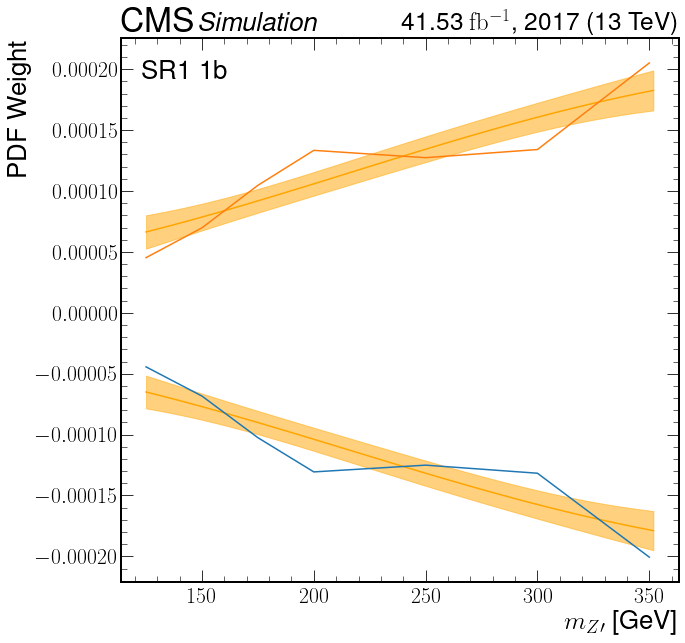

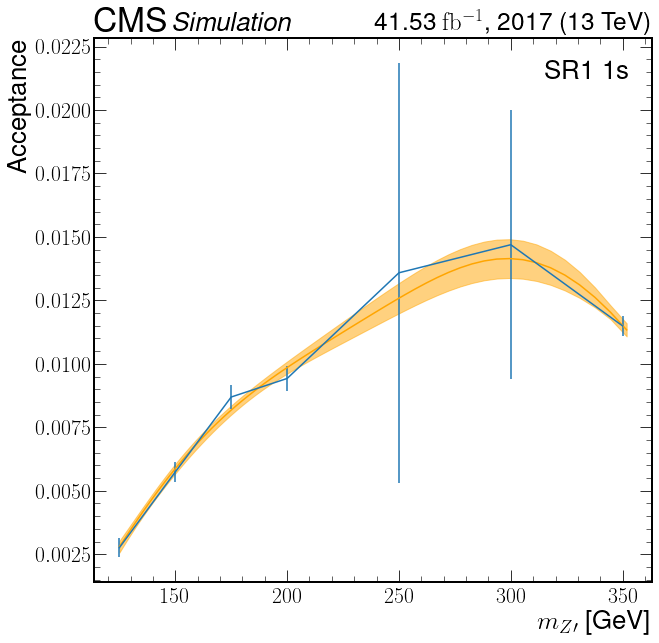

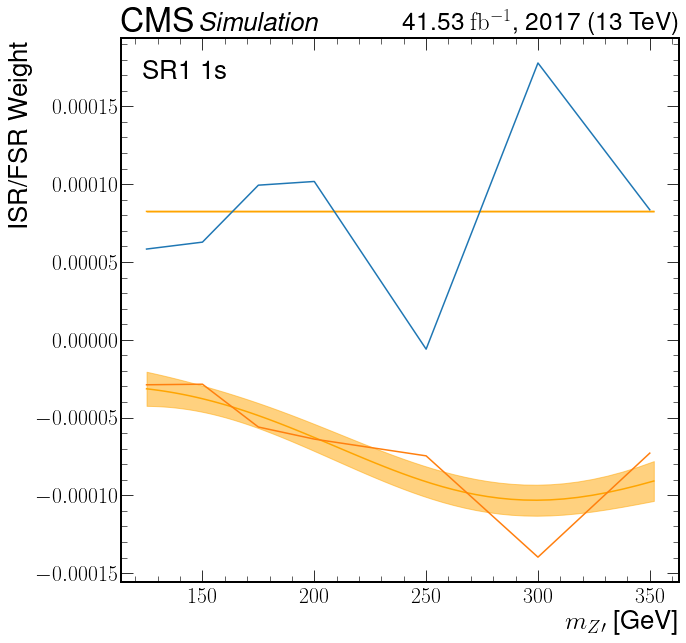

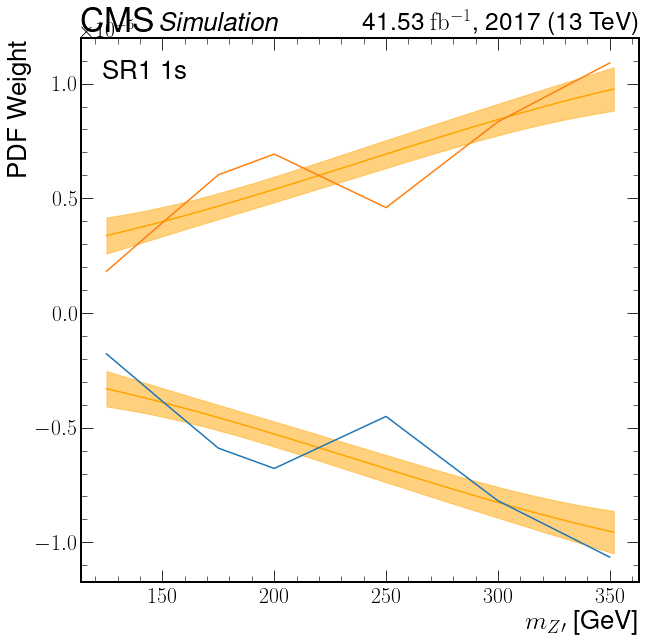

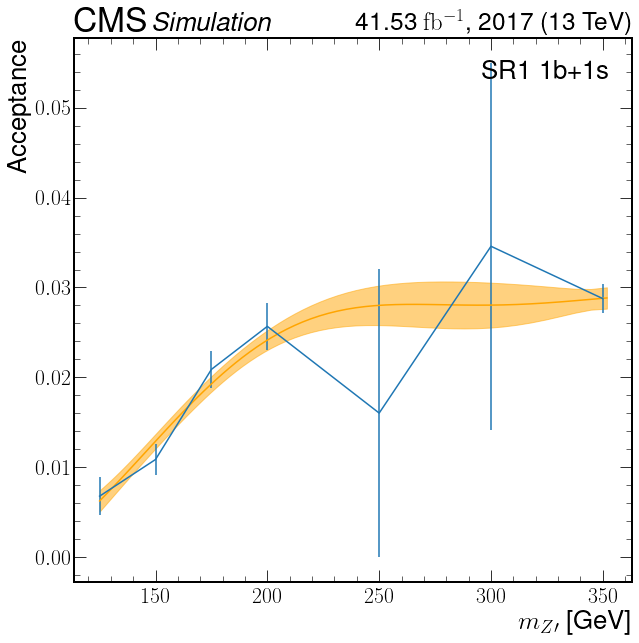

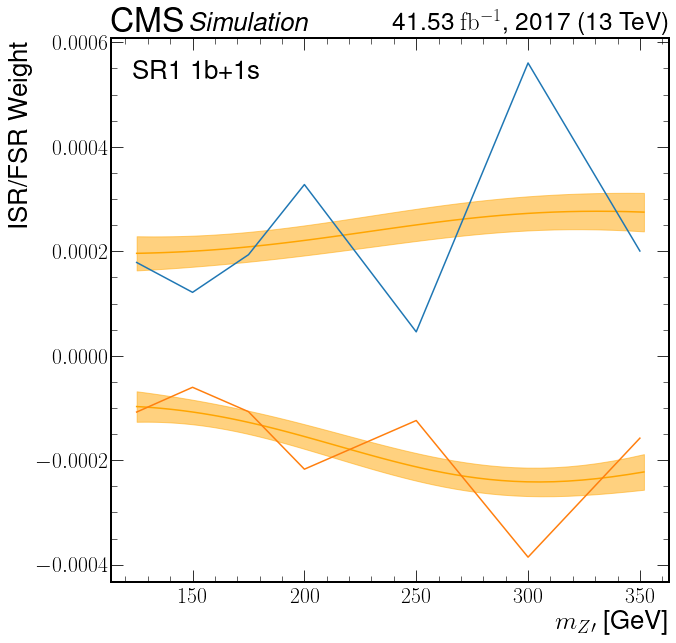

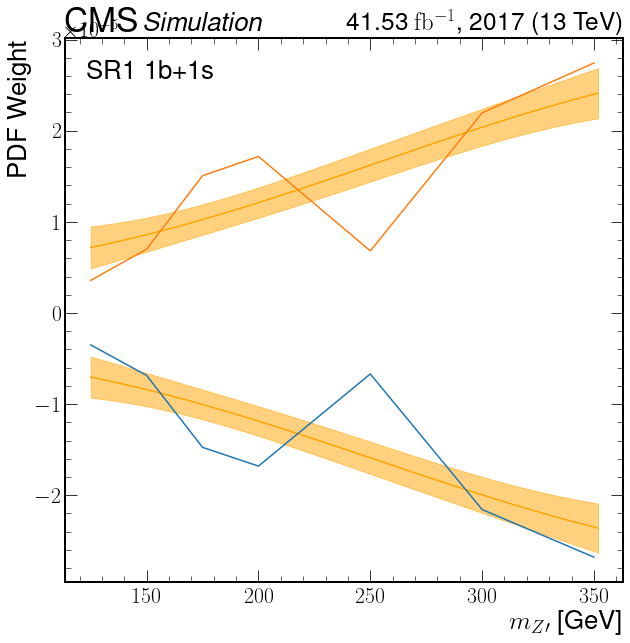

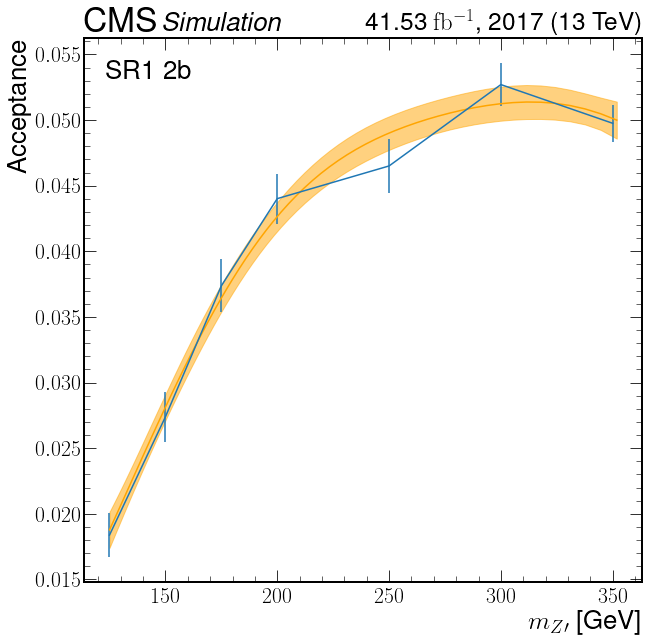

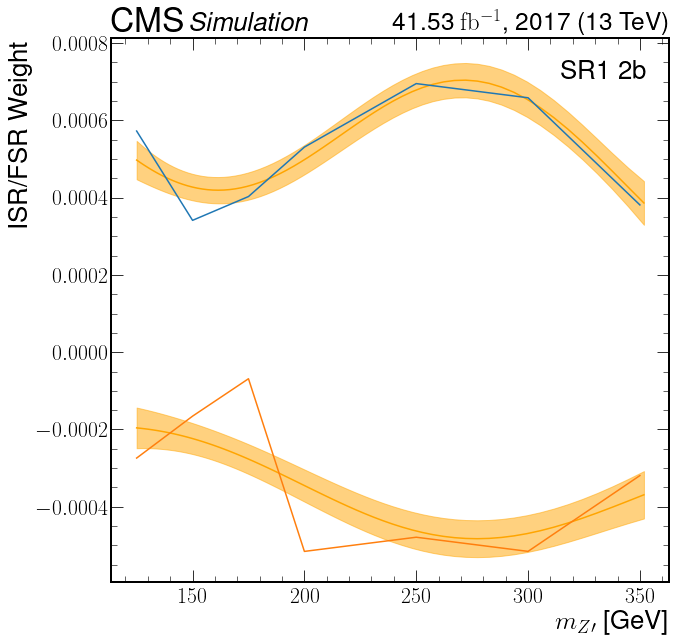

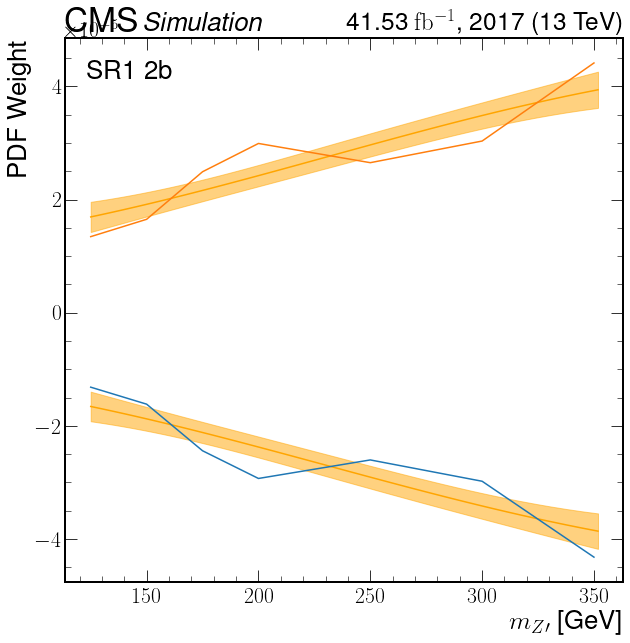

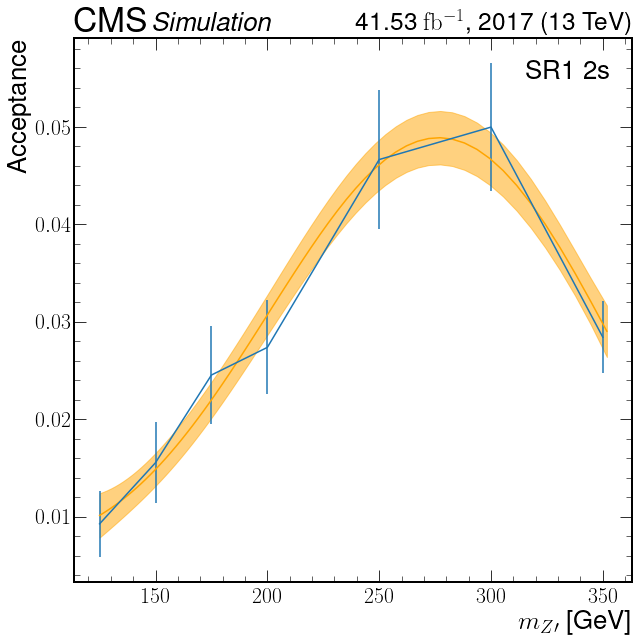

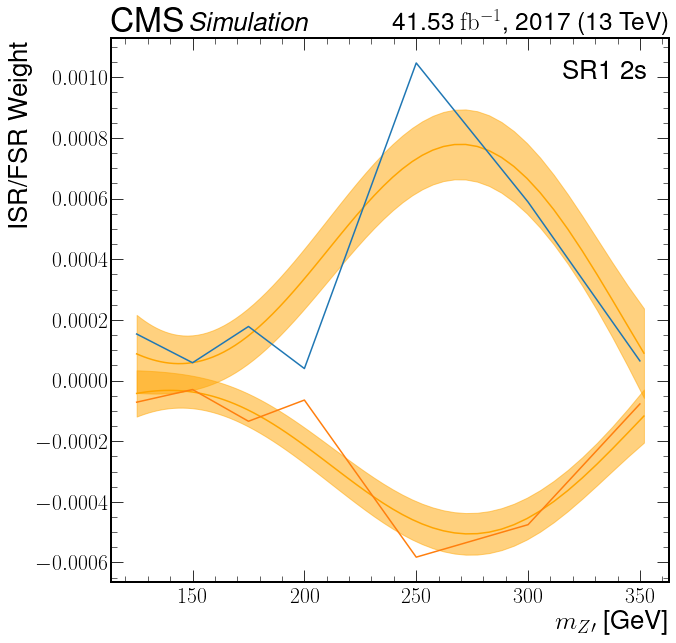

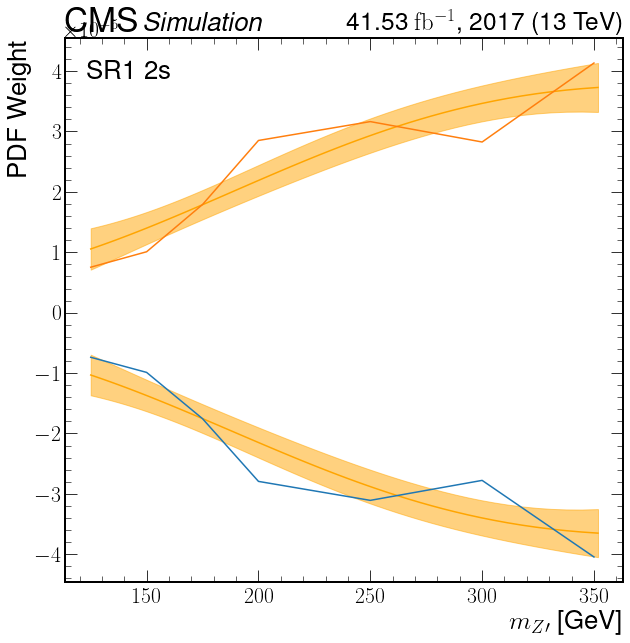

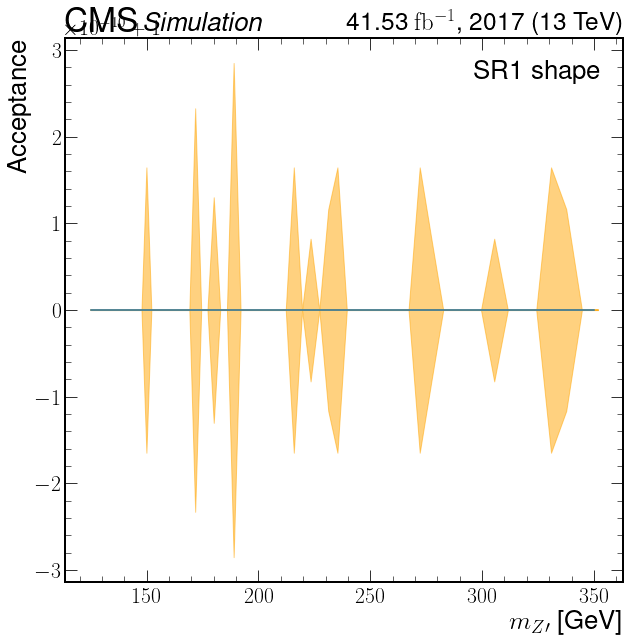

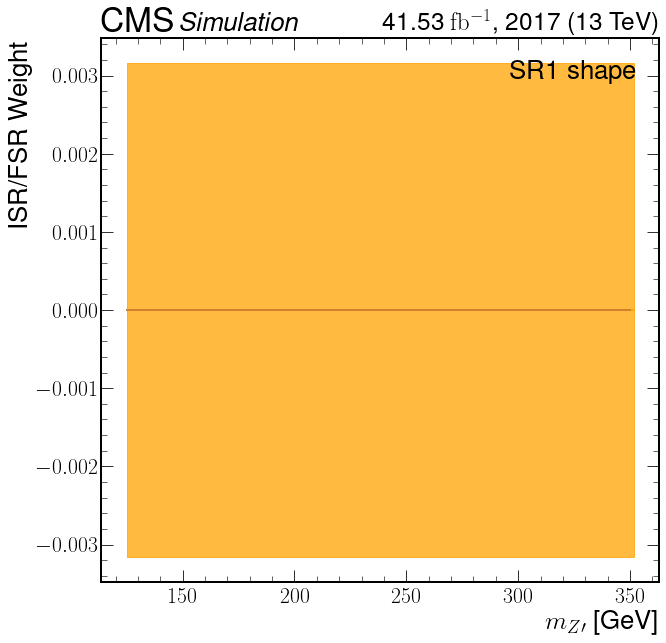

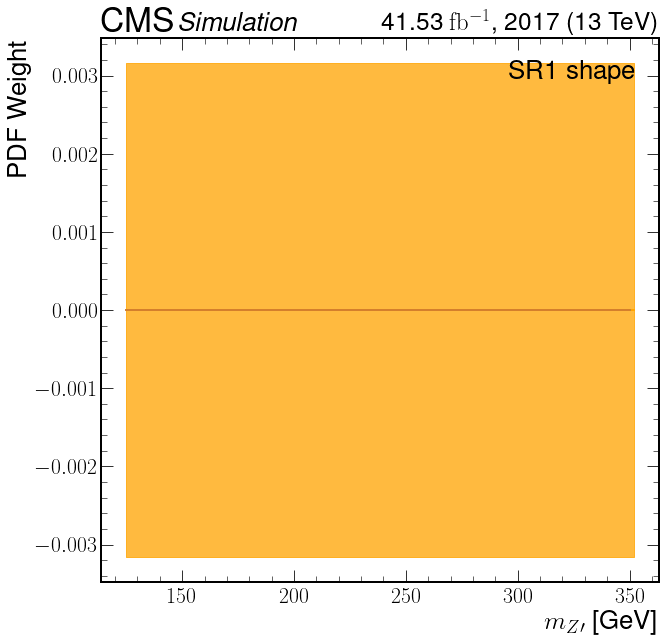

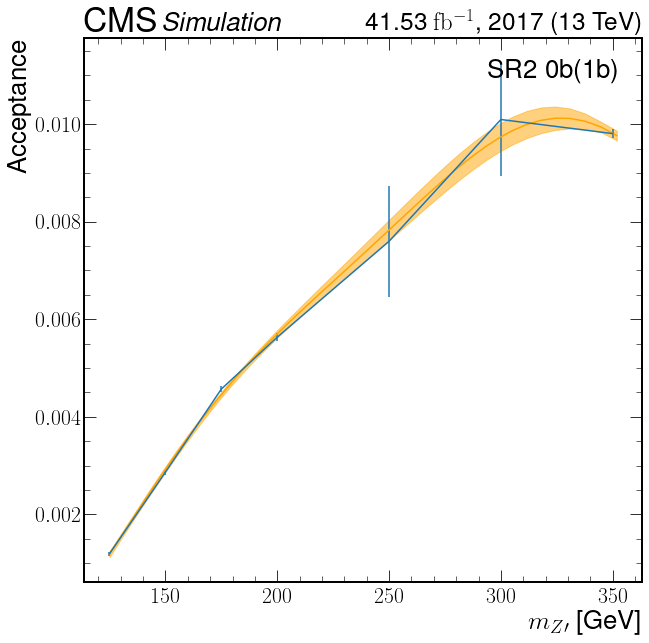

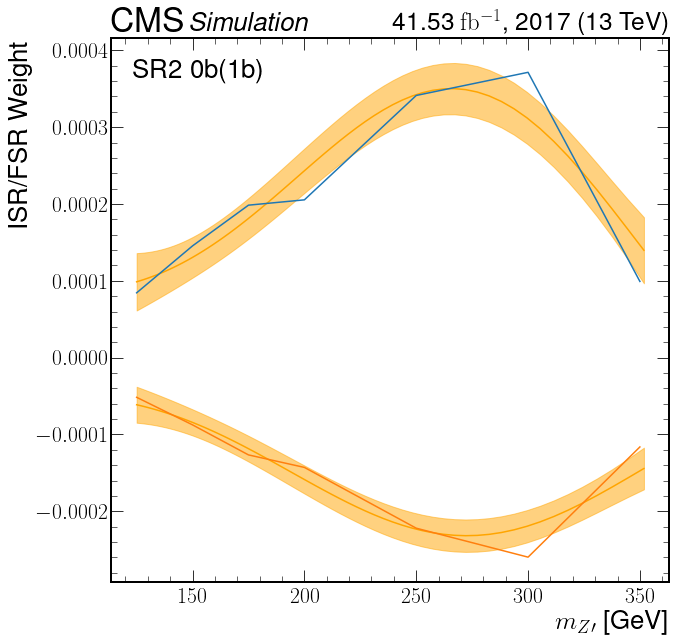

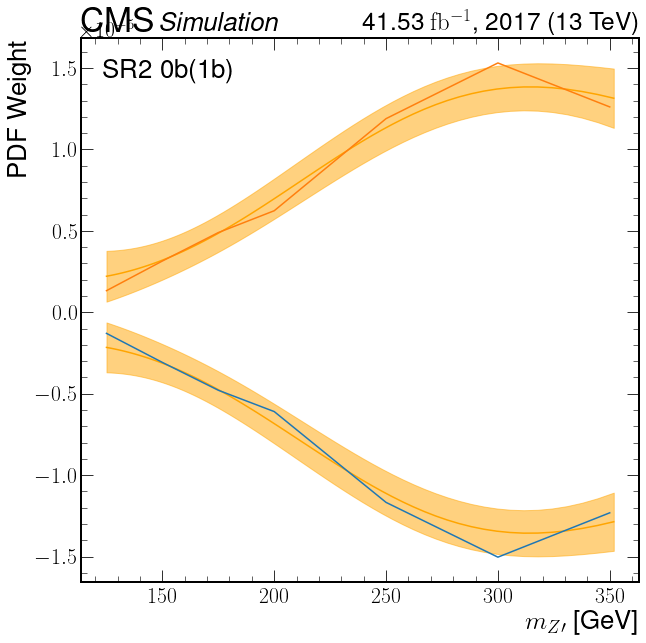

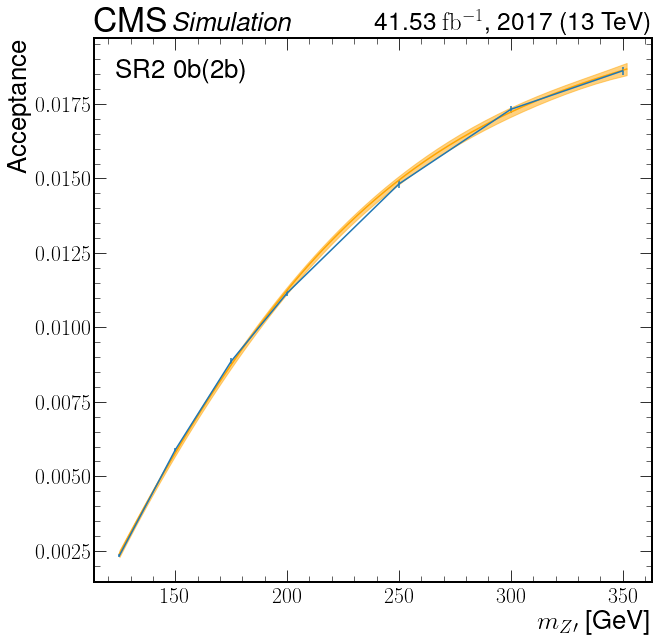

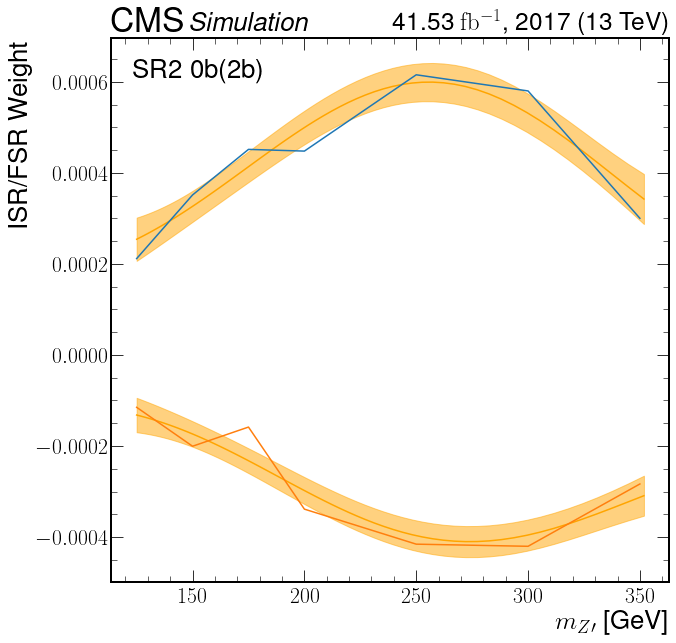

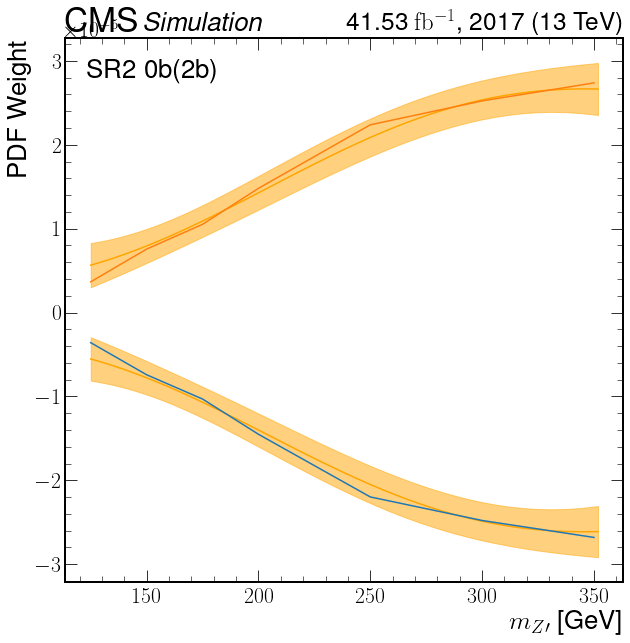

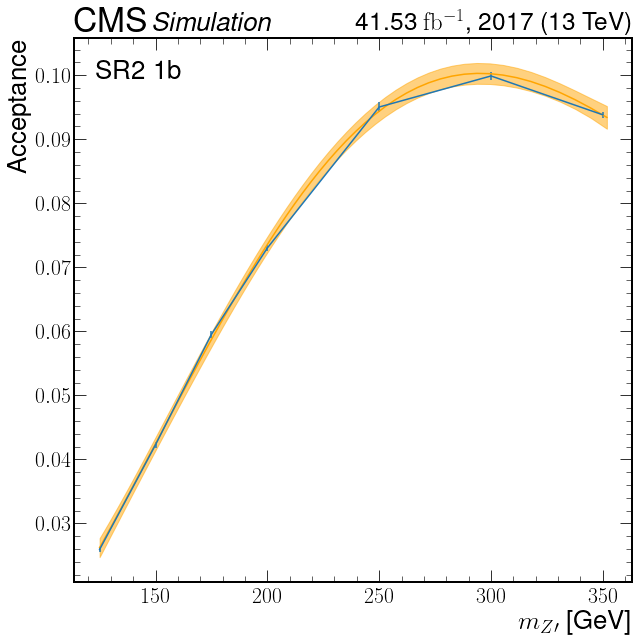

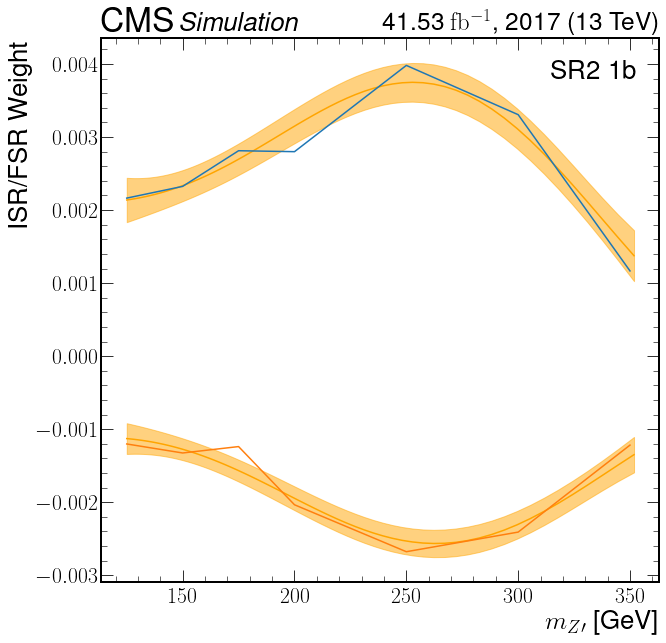

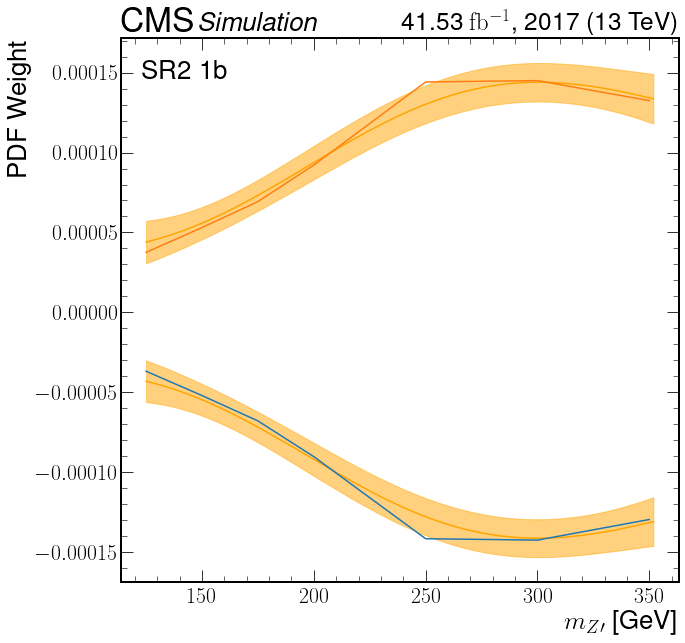

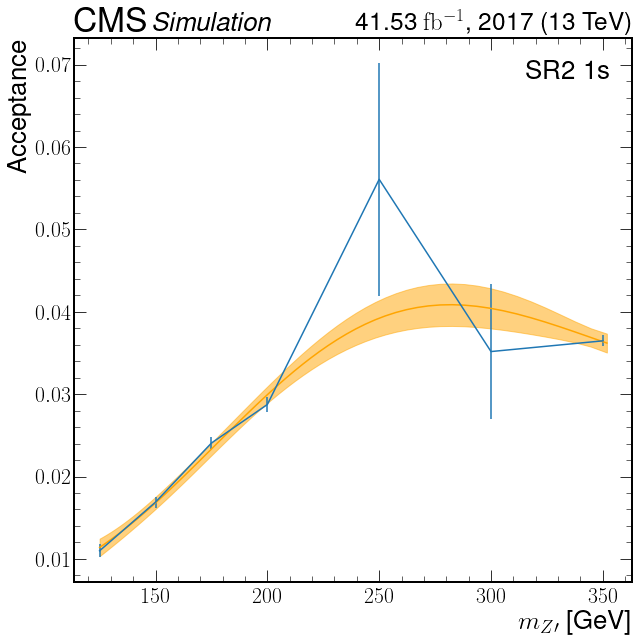

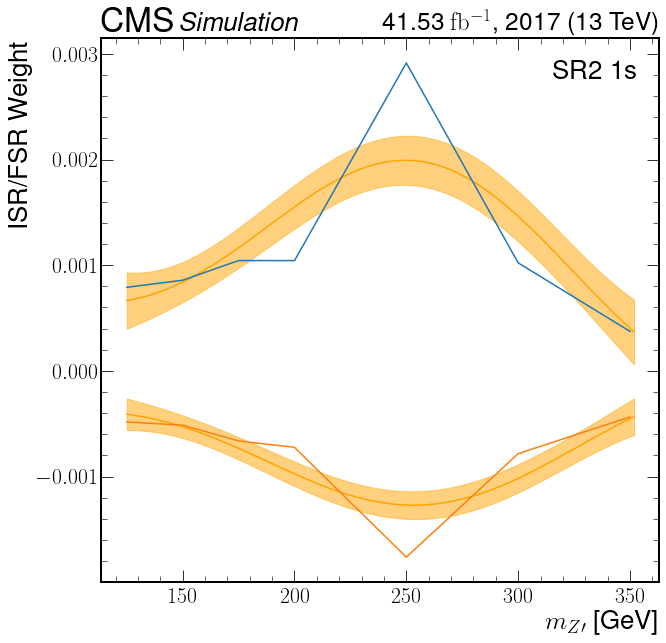

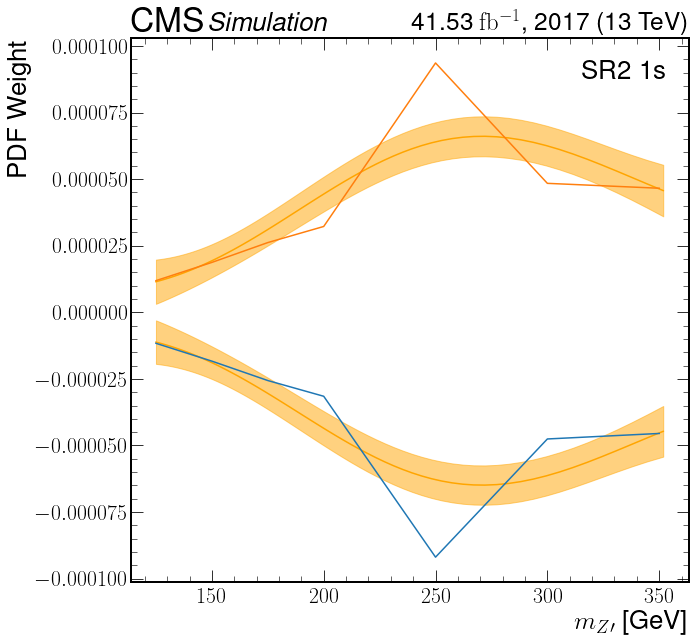

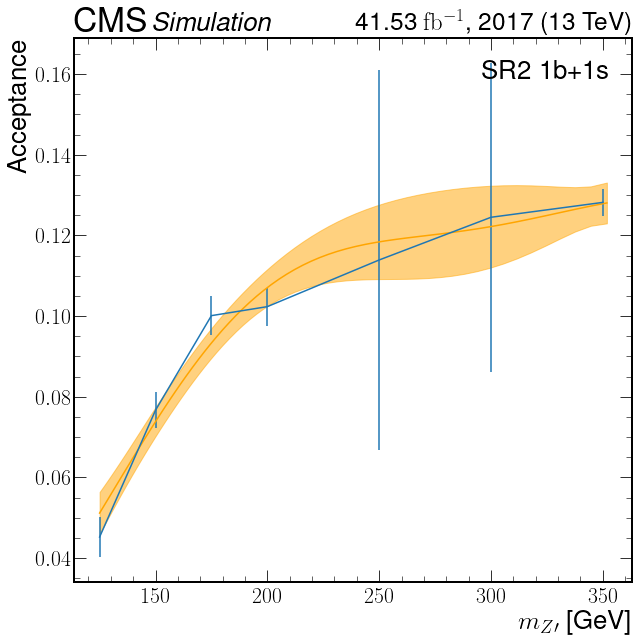

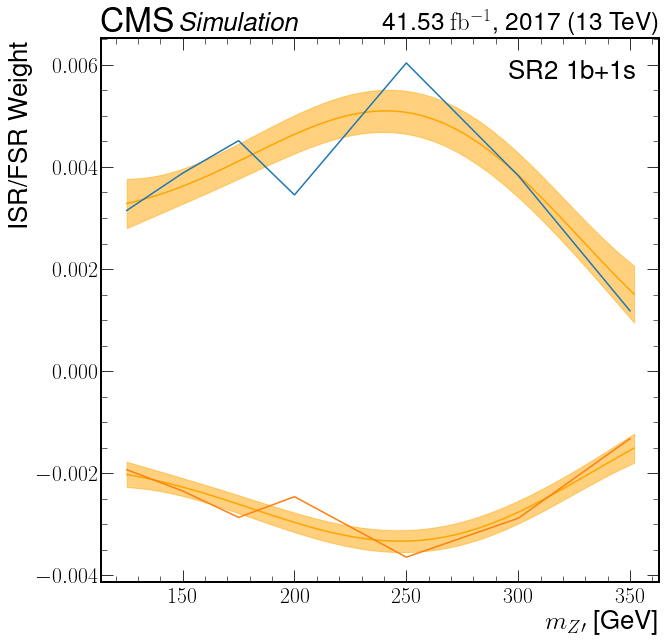

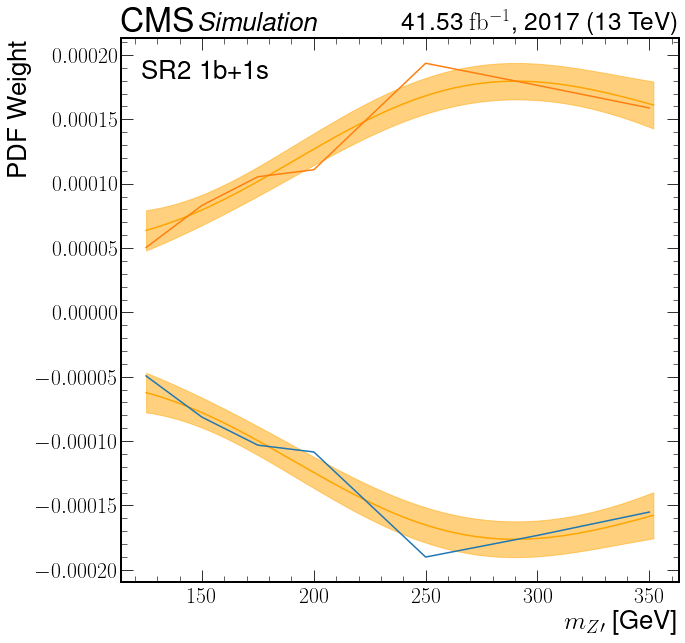

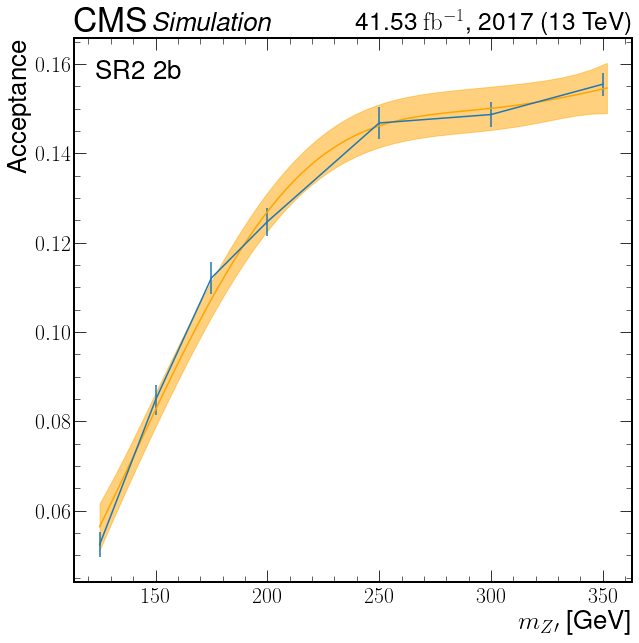

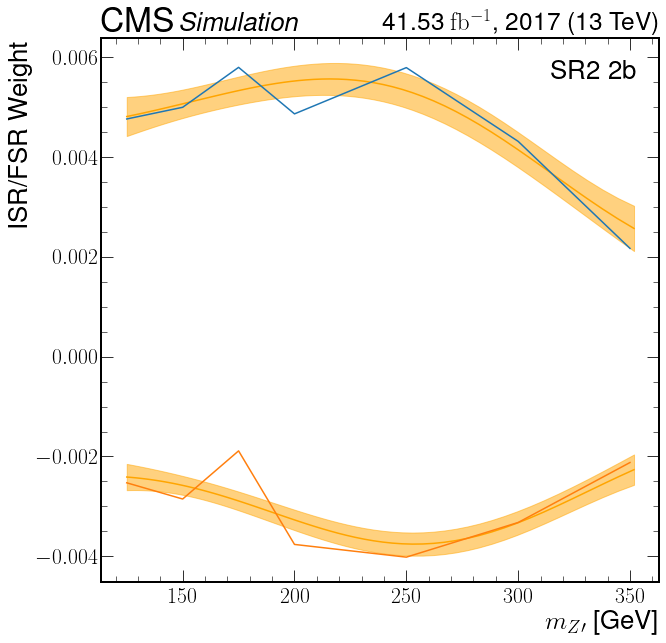

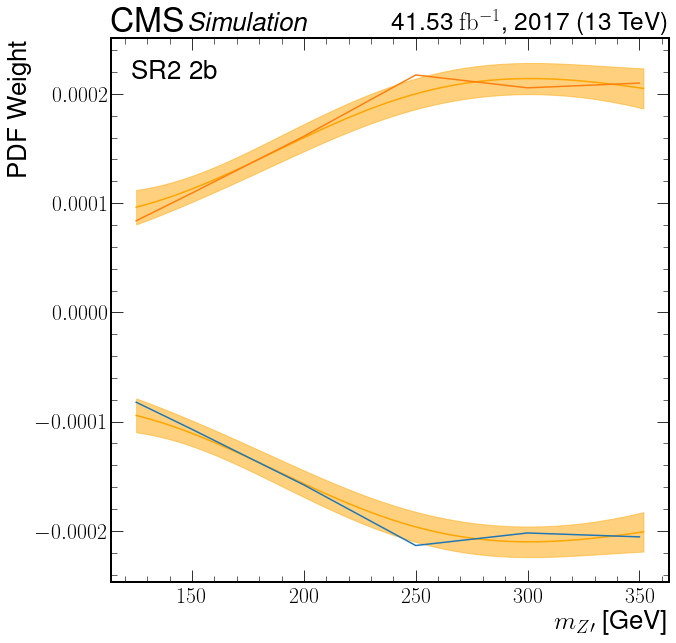

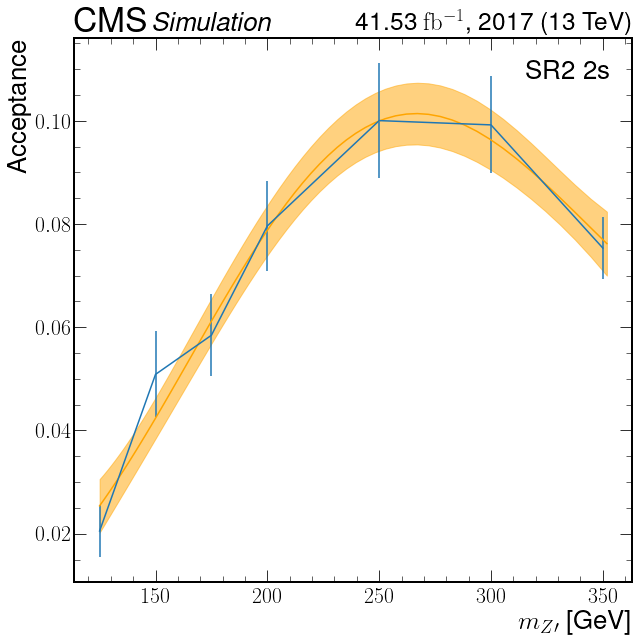

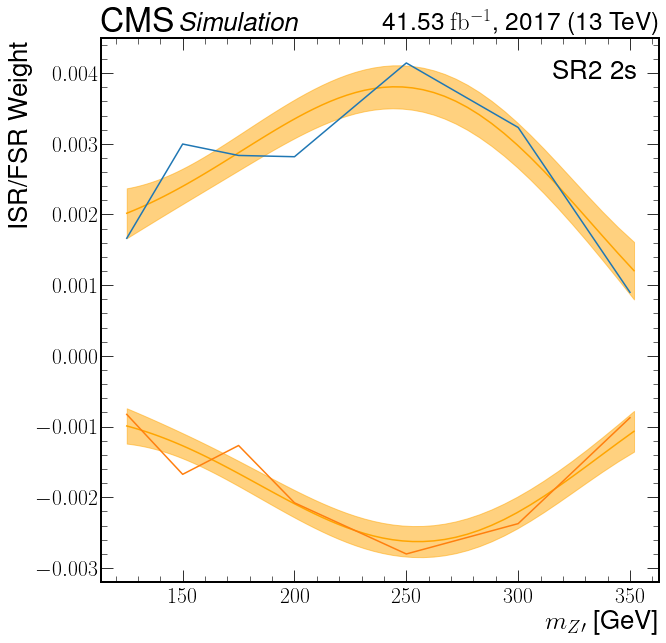

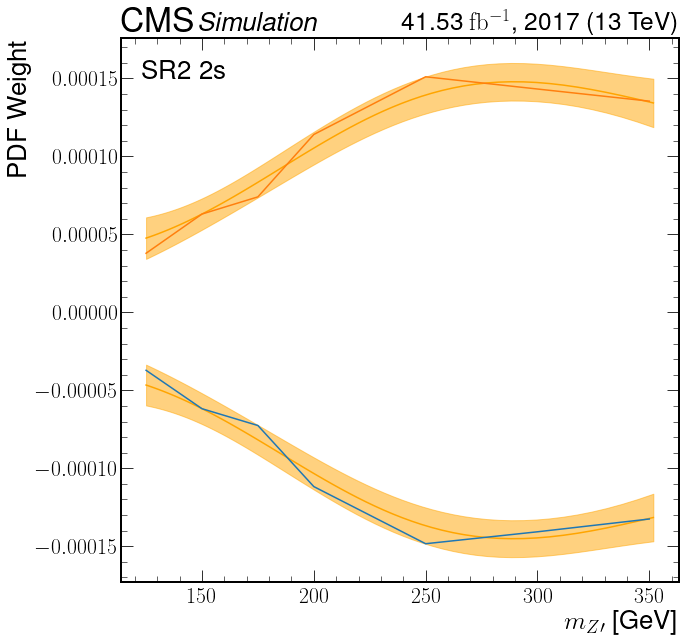

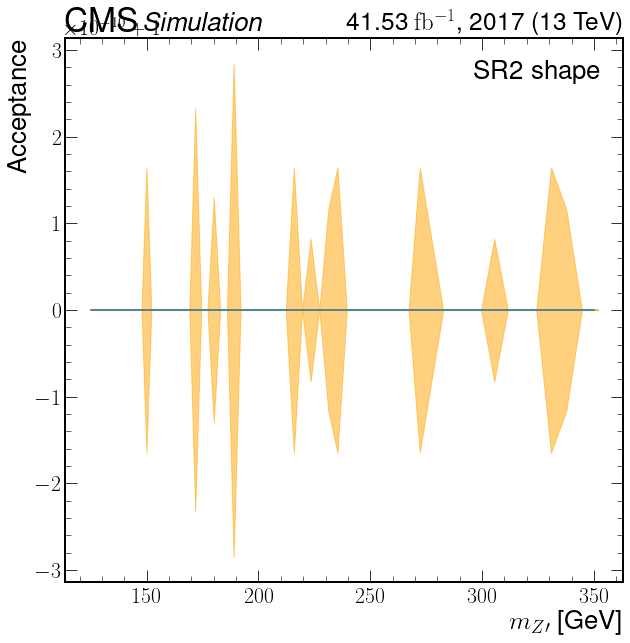

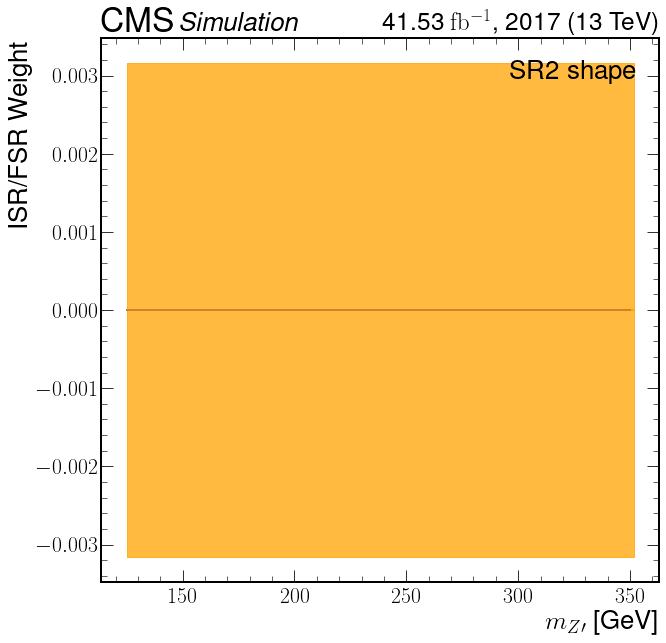

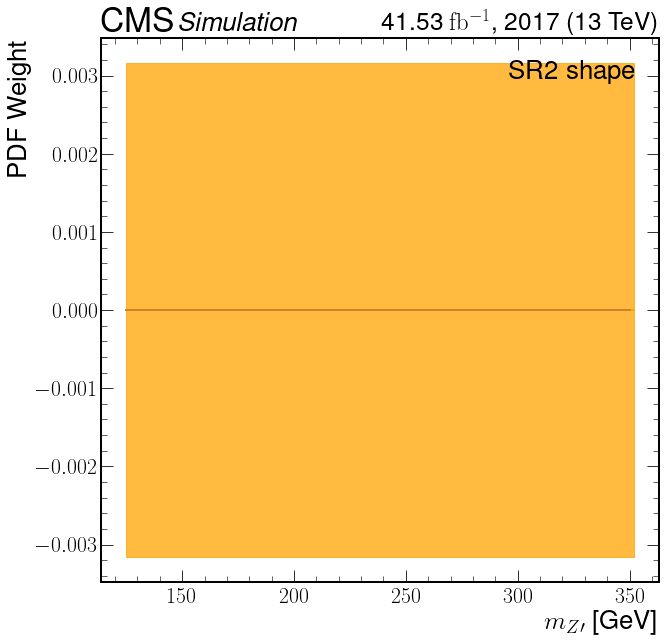

In [19]:
df_list = []
for reg in ['SR1', 'SR2']:
    for sig_type in accpt_df.type.unique():
        df_list+= extend_accpt_df(reg, sig_type)

In [20]:
accpt_df_interpolated = pd.DataFrame(df_list)
accpt_df_interpolated

,mass,reg,type,acceptance,statistical,Weight_ISRFSR_Up,Weight_ISRFSR_Down,Weight_PDF_Up,Weight_PDF_Down
0,125.0,SR1,0b(1b),0.011043,5.058154e-04,0.000237,-0.000122,-0.000014,0.000015
1,126.7,SR1,0b(1b),0.012219,4.687967e-04,0.000241,-0.000125,-0.000015,0.000015
2,128.4,SR1,0b(1b),0.013384,4.420488e-04,0.000246,-0.000127,-0.000015,0.000015
3,130.2,SR1,0b(1b),0.014605,4.239055e-04,0.000250,-0.000130,-0.000015,0.000015
4,132.0,SR1,0b(1b),0.015812,4.146582e-04,0.000255,-0.000134,-0.000015,0.000016
...,...,...,...,...,...,...,...,...,...
1003,324.2,SR2,shape,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1004,330.8,SR2,shape,1.000000,1.646361e-10,0.000000,0.000000,0.000000,0.000000
1005,337.6,SR2,shape,1.000000,1.164153e-10,0.000000,0.000000,0.000000,0.000000
1006,344.6,SR2,shape,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000


In [21]:
##
## define template
## 

In [22]:
template = '''#higgs combine tool shape analysis card for z'to mumu 1 jet
#https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/blob/102x/data/tutorials/shapes/simple-shapes-df.txt
-------------------------

imax 1  number of channels                                      #1 Jet
jmax 1  number of backgrounds -1                                    #following AN2015_207_v5, not sure why the -1 is there?
kmax *  number of nuisance parameters (sources of systematic uncertainties)

-------------------------

bin       {reg}_{era}_{binCount}
observation   {obs}

-------------------------

bin       {reg}_{era}_{binCount}      {reg}_{era}_{binCount}
process     ABCD_{reg}_{era}    sig_{reg}_{era}_{mass}_{dbs}
process     1     -1
rate      {abcd_count}   {sig_count}

-------------------------
back_fit_{era}_{binCount} lnN {back_fit}    -    
Closure_{era}_{binCount} lnN  {back_closure}   -  
jer_{era}   lnN -      {jer}
jes_{era}   lnN -      {jes}
roch_{era}   lnN -      {roch}
HEM_{era}   lnN -      {HEM}
btagCorr   lnN -      {btagCorr}
btagUncorr_{era}   lnN -      {btagUncorr}
elSF_{era}   lnN -      {el}
ISRFSR_{era}   lnN -      {ISRFSR}
Muon_{era}   lnN -      {Muon}
trigger_{era}   lnN -      {trigger}
pdf_{era}   lnN -      {pdf}
puid_{era}   lnN -      {puid}
pu   lnN -      {pu}'''
template += lumi_str
print(template)

#higgs combine tool shape analysis card for z'to mumu 1 jet
#https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit/blob/102x/data/tutorials/shapes/simple-shapes-df.txt
-------------------------

imax 1  number of channels                                      #1 Jet
jmax 1  number of backgrounds -1                                    #following AN2015_207_v5, not sure why the -1 is there?
kmax *  number of nuisance parameters (sources of systematic uncertainties)

-------------------------

bin       {reg}_{era}_{binCount}
observation   {obs}

-------------------------

bin       {reg}_{era}_{binCount}      {reg}_{era}_{binCount}
process     ABCD_{reg}_{era}    sig_{reg}_{era}_{mass}_{dbs}
process     1     -1
rate      {abcd_count}   {sig_count}

-------------------------
back_fit_{era}_{binCount} lnN {back_fit}    -    
Closure_{era}_{binCount} lnN  {back_closure}   -  
jer_{era}   lnN -      {jer}
jes_{era}   lnN -      {jes}
roch_{era}   lnN -      {roch}
HEM_{era}   lnN -     

In [ ]:
##
## rebin_signals
##

In [256]:
from time import perf_counter

In [399]:
def rebin_integrate(x,y, xnew_binedges, keep_norm=False, usequad=False, straight_interpolate = False, sample_density=100):
    from scipy.interpolate import interp1d
    from scipy.integrate import quad
    f = interp1d(x,y, fill_value=0, bounds_error=False)
     
    centers = np.array(Bins(bin_edges).calc_bin_centers())
    widths = np.array(Bins(bin_edges).calc_bin_widths())
    if usequad:
        ynew_int = []
        for i, center in enumerate(centers):
            integral = quad(f, xnew_binedges[i], xnew_binedges[i+1])[0]
            ynew_int.append(integral)
        ynew_int = np.array(ynew_int)
    elif straight_interpolate:
        ynew_int = f(centers)*widths
    else:
        ynew_int = []
        for i, (center, width) in enumerate(zip(centers, widths)):
            sample_points = np.linspace(xnew_binedges[i], xnew_binedges[i+1],int(sample_density*width))
            integral = f(sample_points).sum()/sample_density
            ynew_int.append(integral)
        ynew_int = np.array(ynew_int)
        
    
    
    if keep_norm:  
        y_total = y[(x>=np.min(bin_edges)) & (x<=np.max(bin_edges))].sum()
        return centers, ynew_int/ynew_int.sum()*y_total
    return centers, ynew_int

In [426]:
rebinned = []

start = perf_counter()
for i, row in data.iterrows():
    
    x, y = row.x, row.y
    xnew, ynew = rebin_integrate(x, y, bin_edges, keep_norm=True, sample_density=2)
    rebinned.append(ynew)
    if i%1000==10: 
        end = perf_counter()
        elapsed_time_min = (end-start)/60
        time_per = elapsed_time_min/i
        nremaining = len(data)-i
        time_remaining = time_per*nremaining
        print("ratio done:{:.2f} elapsed minutes: {:.1f} est time remaining: {:.1f}".format(i/len(data), elapsed_time_min, time_remaining))
        
end = perf_counter()
print(end-start)
data['rebinned'] = rebinned

ratio done:0.00 elapsed minutes: 0.0 est time remaining: 9.6
ratio done:0.02 elapsed minutes: 0.2 est time remaining: 8.7
ratio done:0.05 elapsed minutes: 0.4 est time remaining: 8.3
ratio done:0.07 elapsed minutes: 0.6 est time remaining: 7.9
ratio done:0.10 elapsed minutes: 0.8 est time remaining: 7.6
ratio done:0.12 elapsed minutes: 1.0 est time remaining: 7.3
ratio done:0.15 elapsed minutes: 1.2 est time remaining: 7.1
ratio done:0.17 elapsed minutes: 1.4 est time remaining: 6.9
ratio done:0.20 elapsed minutes: 1.6 est time remaining: 6.7
ratio done:0.22 elapsed minutes: 1.8 est time remaining: 6.5
ratio done:0.24 elapsed minutes: 2.0 est time remaining: 6.3
ratio done:0.27 elapsed minutes: 2.2 est time remaining: 6.1
ratio done:0.29 elapsed minutes: 2.4 est time remaining: 5.9
ratio done:0.32 elapsed minutes: 2.6 est time remaining: 5.7
ratio done:0.34 elapsed minutes: 2.8 est time remaining: 5.5
ratio done:0.37 elapsed minutes: 3.0 est time remaining: 5.2
ratio done:0.39 elapsed 

In [23]:
def get_sig_bin(reg, mass, dbs, sys, nBin):
    tdf =  data[(data.reg==reg) & (data.mass==mass) & (data.dbs==dbs) & (data.sys==sys)]
    assert tdf.shape[0]==1, "more than length one"
    row =tdf.iloc[0]
    x, y = row.x, row.y
    y_prime = rebin_np(x, bin_edges, y) 
    return y_prime[nBin]

def get_sig_bins(reg, mass, dbs, sys, nBin, nom):
    nom = nom+.001
    down = get_sig_bin(reg, mass, dbs, sys.format("Down"), nBin)
    up = get_sig_bin(reg, mass, dbs, sys.format("Up"), nBin)
    x = [down/nom, up/nom]
    if x == [0,0]: x = [1,1]
    if (x[0]==x[1]): string = "{:.2f}".format(x[0])
    else: string =  "{:.2f}/{:.2f}".format(*x)
    if string == "1.00/1.00": string = "1.00"
    return string

def get_norm_bin(reg, mass, dbs, sys, norm):
    tdf =  data[(data.reg==reg) & (data.mass==mass) & (data.dbs==dbs) & (data.sys==sys)]
    assert tdf.shape[0]==1, "more than length one"
    row =tdf.iloc[0]
    return norm/row.y.sum()

In [430]:
data

,reg,sys,mass,dbs,norm,x,y,rebinned
0,SR1,nom,125.0,0.04,1354.458762,"[116.81709855980341, 116.98705155296395, 117.1...","[0.8464604310929357, 0.908727851142682, 0.9763...","[53.81237240384406, 102.26360257639584, 195.00..."
1,SR1,nom,126.7,0.04,1379.487596,"[118.33330952284973, 118.50681383424325, 118.6...","[0.8921398834462372, 0.9548627548270421, 1.022...","[21.595495261681354, 36.80889984396473, 66.499..."
2,SR1,nom,128.4,0.04,1404.516430,"[119.84889846354139, 120.02596678750169, 120.2...","[0.9372578980074331, 1.0004711290705417, 1.068...","[10.375538508505489, 16.15991072388501, 26.302..."
3,SR1,nom,130.2,0.04,1431.017548,"[121.45296224934029, 121.63381805908419, 121.8...","[0.9843496336448372, 1.0481208163039408, 1.117...","[3.301104116517546, 8.116372471514119, 12.0844..."
4,SR1,nom,132.0,0.04,1457.518666,"[123.05632979733326, 123.2409873017956, 123.42...","[1.0306720724260843, 1.0950415831971707, 1.164...","[0.0, 0.0, 3.852139812014703, 9.43445537685614..."
...,...,...,...,...,...,...,...,...
40981,SR2,Weight_MuonTriggerDown,366.9,1.00,136.704104,"[326.5393137687017, 327.33757163885303, 328.13...","[0.10561929144642772, 0.1116651507531023, 0.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40982,SR2,Weight_MuonTriggerDown,374.8,1.00,130.818995,"[333.1918255572788, 334.01461538247787, 334.83...","[0.1010723833157687, 0.10685796851473178, 0.11...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40983,SR2,Weight_MuonTriggerDown,382.9,1.00,124.784897,"[340.00039085006256, 340.8485860295188, 341.69...","[0.09641036358686518, 0.10192908546020002, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
40984,SR2,Weight_MuonTriggerDown,391.3,1.00,118.527313,"[347.0479575332066, 347.922767734427, 348.7975...","[0.09157567646059482, 0.0968176511814263, 0.10...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [429]:
def get_sig_bin(reg, mass, dbs, sys, nBin):
    tdf =  data[(data.reg==reg) & (data.mass==mass) & (data.dbs==dbs) & (data.sys==sys)]
    assert tdf.shape[0]==1, "more than length one"
    row =tdf.iloc[0]
    y_prime = row.rebinned[nBin]
    return y_prime

def get_sig_bins(reg, mass, dbs, sys, nBin, nom):
    nom = nom+.001
    down = get_sig_bin(reg, mass, dbs, sys.format("Down"), nBin)
    up = get_sig_bin(reg, mass, dbs, sys.format("Up"), nBin)
    x = [down/nom, up/nom]
    if x == [0,0]: x = [1,1]
    if (x[0]==x[1]): string = "{:.2f}".format(x[0])
    else: string =  "{:.2f}/{:.2f}".format(*x)
    if string == "1.00/1.00": string = "1.00"
    return string

def get_norm_bin(reg, mass, dbs, sys, norm):
    tdf =  data[(data.reg==reg) & (data.mass==mass) & (data.dbs==dbs) & (data.sys==sys)]
    assert tdf.shape[0]==1, "more than length one"
    row =tdf.iloc[0]
    return norm/row.y.sum()

In [436]:
def make_bin_card(reg, mass, dbs, nBin, norm, stat_err, ISRFSR="0.97/1.03", pdf="1.0", verbose=False):
    bin_edges = abcd[reg]['bins']
    nom = abcd[reg]['nom'][nBin]
    std = abcd[reg]['std'][nBin]
    target = Bins(bin_edges).calc_bin_centers()[nBin]
    #use new get value function to ensure matching data value
    obs = data_dict[reg].get_value_at(target)[0]
    if verbose: print(obs, nom)
    #blinded
    obs = obs
    #signal 
    sig_nom = get_sig_bin(reg, mass, dbs, 'nom', nBin)
    jes = get_sig_bins(reg, mass, dbs, 'Reg_jet_jesTotal{}_muon_corrected_pt_ele_pt', nBin, sig_nom)
    roch = get_sig_bins(reg, mass, dbs, 'Reg_jet_nom_muon_corrected{}_pt_ele_pt', nBin, sig_nom)
    jer = get_sig_bins(reg, mass, dbs, 'Reg_jet_jer{}_muon_corrected_pt_ele_pt', nBin, sig_nom)
    pu = get_sig_bins(reg, mass, dbs, 'Weight_Pu{}', nBin, sig_nom)
    btagCorr = get_sig_bins(reg, mass, dbs, 'Weight_BTagCorr{}', nBin, sig_nom)
    btagUncorr = get_sig_bins(reg, mass, dbs, 'Weight_BTagUncorr{}', nBin, sig_nom)
    puid = get_sig_bins(reg, mass, dbs, 'Weight_PUID{}', nBin, sig_nom)
    #pdf = get_sig_bins(reg, mass, dbs, 'Weight_PDF_{}', nBin, sig_nom)\
    pdf = pdf
    #fixed 2% width
    ISRFSR  = ISRFSR #= get_sig_bins(reg, mass, dbs, 'Weight_ISRFSR_{}', nBin, sig_nom)
    muon = get_sig_bins(reg, mass, dbs, 'Weight_MuonSF{}', nBin, sig_nom)
    el = get_sig_bins(reg, mass, dbs, 'Weight_ElectronSF{}', nBin, sig_nom)
    trigger = get_sig_bins(reg, mass, dbs, 'Weight_MuonTrigger{}', nBin, sig_nom)
    try:
        HEM = get_sig_bins(reg, mass, dbs, "Reg_jet_jesHEMIssue{}_muon_corrected_pt_ele_pt", nBin, sig_nom)
    except:
        HEM = "1.00"
        
    #scale sig_nom 
    norm_factor = get_norm_bin(reg, mass, dbs, 'nom', norm)
    sig_nom = sig_nom*norm_factor
    
    value_dict = {
                "era": era,
                "reg": reg,
                "binCount": nBin,
                "lumi": lumi, 
                "mass": mass, 
                "dbs": dbs,
                "obs": "{:.2f}".format(obs),
        
                "abcd_count": "{:.2f}".format(nom),
                "back_fit": "{:.2f}".format((nom+std)/nom),
                "back_closure": "{:.2f}".format(uncertainty_dict[reg]),
        
                "sig_count": "{:.2f}".format(sig_nom),
                "jer": jer,
                "jes": jes,
                "roch": roch,
                "HEM": HEM,
                "btagCorr": btagCorr,
                "btagUncorr": btagUncorr,
                "el": el,
                "ISRFSR": ISRFSR,
                "Muon": muon,
                "trigger": trigger,
                "pdf": pdf,
                "puid": puid,
                "pu": pu,
                "stat": "{:.2f}".format(1+stat_err/norm),
                 }
    return template.format(**value_dict), sig_nom

In [437]:
#path = '/afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/CMSSW_12_1_0/src/bff_plotting_code_v3/exo-datacards/EXO-22-006/combine_data/model_ind'
path = '{}/combine_data/model_ind'.format(outdir)
path

'/eos/cms/store/group/phys_exotica/bffZprime/assets_june_23/combine_data/model_ind'

In [438]:
import os

In [439]:
data.mass.unique()

array([125. , 126.7, 128.4, 130.2, 132. , 133.8, 135.7, 137.6, 139.5,
       141.5, 143.5, 145.6, 147.7, 149.9, 152.1, 154.4, 156.7, 159.1,
       161.5, 164. , 166.5, 169.1, 171.7, 174.4, 177.2, 180. , 182.9,
       185.9, 188.9, 192. , 195.2, 198.4, 201.7, 205.1, 208.6, 212.2,
       215.8, 219.5, 223.3, 227.2, 231.2, 235.3, 239.5, 243.8, 248.2,
       252.7, 257.4, 262.2, 267.1, 272.1, 277.3, 282.6, 288.1, 293.7,
       299.5, 305.4, 311.5, 317.8, 324.2, 330.8, 337.6, 344.6, 351.8,
       359.2, 366.9, 374.8, 382.9, 391.3, 400. ])

In [448]:
bin_centers = calc_bin_centers(abcd['SR1']['bins'])
reg, mass, dbs, fs_type = 'SR1', 250, 0.04, '1b'
bin_edges = abcd[reg]['bins']

def make_card(reg, mass, dbs, fs_type):
    combine_str = 'combineCards.py '
    
    signal = '{}_{}_{}_{}'.format(reg, mass, str(dbs).replace('.', 'p'), fs_type.replace('(','-').replace(')','-'))
    path_prime = '{}/{}/{}'.format(path, era, signal)

    acceptance_row = accpt_df_interpolated[(accpt_df_interpolated.reg==reg) & (accpt_df_interpolated.mass==mass) & (accpt_df_interpolated.type==fs_type)]
    assert acceptance_row.shape[0] == 1, acceptance_row
    acceptance = acceptance_row.iloc[0]['acceptance']
    stat_error = acceptance_row.iloc[0]['statistical']
    norm = acceptance*1000*lumi_fraction
    
    print(norm, acceptance, lumi_fraction)
    isrfsr = get_sys(acceptance_row.iloc[0], "Weight_ISRFSR")
    pdf = get_sys(acceptance_row.iloc[0], "Weight_PDF")
    print(isrfsr, pdf)
    os.makedirs(path_prime, exist_ok=True)
    
    for i in range(len(bin_centers)):
        # don't count 0 sig bins for speed
        sig_count = get_sig_bin(reg, mass, dbs, 'nom', i)
        if sig_count==0: continue
        print("nbin, sign", i, sig_count)
        template_filled, sig_nom = make_bin_card(reg, mass, dbs, i, norm, stat_error, ISRFSR=isrfsr, pdf=pdf)
        with open('{}/bin_{}.txt'.format(path_prime, i), 'w') as f:
            f.write(template_filled)
            combine_str+= ' Name{}={}/bin_{}.txt'.format(i,signal, i)
    combine_str += ' > datacard_{}.txt\n'.format(signal)
    return combine_str

In [449]:


def get_sys(row, string):
    syses = sorted([1+row[string+"_Up"]/row['acceptance'], 1+row[string+"_Down"]/row['acceptance']])

    syses_string = ["{:.2f}".format(sys) for sys in syses]
    if syses_string[0]=="1.00" and syses_string[1]=="1.00": syses_string="1.00"
    else: syses_string = "{}/{}".format(*syses_string)
    return syses_string

In [450]:
masses = [164.0]
accpt_df.type.unique()

array(['0b(1b)', '0b(2b)', '1b', '1s', '1b+1s', '2b', '2s', 'shape'],
      dtype=object)

In [451]:
combine_sh = '#!bin/bash\n'
dbs = 0.5

for fs_type in accpt_df.type.unique():
    for mass in masses:
        print(fs_type, mass)
        for reg in ['SR1', 'SR2']:
            if fs_type!='0b(1b)': continue
            if reg!='SR2': continue
            #print(fs_type, mass, reg)f
            combine_sh += make_card(reg, mass, dbs, fs_type)



0b(1b) 164.0
1.0068345223226827 0.0038149351027583225 0.2639191742985899
0.97/1.04 1.00
nbin, sign 30 0.9077555674142432
nbin, sign 31 2.0545349138317204
nbin, sign 32 2.617802125612649
nbin, sign 33 3.391393678024327
nbin, sign 34 4.478415894066791
nbin, sign 35 6.045153973499379
nbin, sign 36 8.37086463742998
nbin, sign 37 11.945702121796646
nbin, sign 38 17.672756745556338
nbin, sign 39 27.316118903828308
nbin, sign 40 43.71247771867737
nbin, sign 41 63.93025593689856
nbin, sign 42 77.27205188635041
nbin, sign 43 75.5738999614184
nbin, sign 44 59.767870342891605
nbin, sign 45 38.52592880797565
nbin, sign 46 21.26054653955958
nbin, sign 47 11.290896448933532
nbin, sign 48 6.33611146694443
nbin, sign 49 3.7183407654018996
nbin, sign 50 2.259942313881639
nbin, sign 51 1.413579232956508
nbin, sign 52 0.9059808979978579
nbin, sign 53 0.5931462469379117
nbin, sign 54 0.39581560449173775
nbin, sign 55 0.15944074937181085
0b(2b) 164.0
1b 164.0
1s 164.0
1b+1s 164.0
2b 164.0
2s 164.0
shape 16

In [ ]:
with open('{}/{}/make_combine.sh'.format(path, era), 'w') as f:
    f.write(combine_sh)


In [ ]:
for fs_type in accpt_df.type.unique():
    for mass in [125, 150, 175, 200, 250, 300, 350]:
        combine_sh_all_years ='combineCards.py '
        i = 0
        for era in [2016, 2017, 2018]:
            for reg in ['SR1', 'SR2']:
                combine_sh_all_years += " Name{i}={era}/datacard_{reg}_{mass}_0p5_{fs_type}.txt".format(i=i, era=era, reg=reg,mass=mass, 
                                                                                                        fs_type=fs_type.replace('(','-').replace(')','-'))
                i+=1
        combine_sh_all_years += ' > 201X/datacard_{}_0p5_{}.txt'.format(mass, fs_type.replace('(','-').replace(')','-'))
        print(combine_sh_all_years)
    
for fs_type in accpt_df.type.unique():
    for mass in [125, 150, 175, 200, 250, 300, 350]:
        combine_sh_all_years ='combineCards.py '
        i = 0
        for era in [2016, 2017, 2018]:
            for reg in ['SR1']:
                combine_sh_all_years += " Name{i}={era}/datacard_{reg}_{mass}_0p5_{fs_type}.txt".format(i=i, era=era, reg=reg,mass=mass, 
                                                                                                        fs_type=fs_type.replace('(','-').replace(')','-'))
                i+=1
        combine_sh_all_years += ' > 201X/datacard_SR1_{}_0p5_{}.txt'.format(mass, fs_type.replace('(','-').replace(')','-'))
        print(combine_sh_all_years)
    
for fs_type in accpt_df.type.unique():
    for mass in [125, 150, 175, 200, 250, 300, 350]:
        combine_sh_all_years ='combineCards.py '
        i = 0
        for era in [2016, 2017, 2018]:
            for reg in ['SR2']:
                combine_sh_all_years += " Name{i}={era}/datacard_{reg}_{mass}_0p5_{fs_type}.txt".format(i=i, era=era, reg=reg,mass=mass, 
                                                                                                        fs_type=fs_type.replace('(','-').replace(')','-'))
                i+=1
        combine_sh_all_years += ' > 201X/datacard_SR2_{}_0p5_{}.txt'.format(mass, fs_type.replace('(','-').replace(')','-'))
        print(combine_sh_all_years)  

In [ ]:
# era combine regions
for fs_type in accpt_df.type.unique():
    fs_string = fs_type.replace('(','-').replace(')','-')
    for dbs in [0.5]:
        dbsstring = str(dbs).replace('.', 'p')
        for mass in [125, 150, 175, 200, 250, 300, 350]:
            for era in [2016, 2017, 2018]:
                combine_sh ='combineCards.py '
                i = 0
                for reg in ['SR1', 'SR2']:
                    combine_sh += f" Name{i}={era}/datacard_{reg}_{mass}_0p5_{fs_string}.txt"
                    i+=1
                combine_sh += f' > {era}/datacard_{mass}_0p5_{fs_string}.txt'
                print(combine_sh)

In [ ]:
run_combine = '''#!/bin/sh
#ulimit -s unlimited
#set -e
cd /afs/cern.ch/work/r/rymuelle/public/nanoAODzPrime/higgscombine/CMSSW_10_2_13/src
export SCRAM_ARCH=slc7_amd64_gcc700
source /cvmfs/cms.cern.ch/cmsset_default.sh
eval `scramv1 runtime -sh`
cd {path} 

combine -M AsymptoticLimits "$1"

'''.format(path=path)

In [ ]:
!cp src/combine_scripts/* {path}

In [ ]:
with open('{}/run_combine.sh'.format(path), 'w') as f:
    f.write(run_combine)

In [ ]:
!mkdir {path}/out
!mkdir {path}/err
!mkdir {path}/log

!mkdir {path}/out/2016
!mkdir {path}/err/2016
!mkdir {path}/log/2016

!mkdir {path}/out/2017
!mkdir {path}/err/2017
!mkdir {path}/log/2017


!mkdir {path}/out/2018
!mkdir {path}/err/2018
!mkdir {path}/log/2018


!mkdir {path}/out/201X
!mkdir {path}/err/201X
!mkdir {path}/log/201X

In [ ]:
condor_submit submit_jobs_201X.sub
condor_submit submit_jobs_2016.sub
condor_submit submit_jobs_2017.sub
condor_submit submit_jobs_2018.sub
watch condor_q